In [1]:
from tidyverse.dummy import *
import scanpy as sc
from sctools import pipeline, adata_merge
import sys
sys.path.append('/users/mstrasse/CRUK-code')
from rnaseqtools import biomart_mapping
# external library
sys.path.append('/users/mstrasse/McGill_analysis/instance-1-backup/infercnvpy/src/')
import infercnvpy as cnv
import matplotlib.pyplot as plt
from crukiopy.cnvnew import CNV_prep
plt.rcParams['svg.fonttype'] = 'none'

Importing tidyverse


In [2]:
reference_field = 'cnv_ref'
reference_cats = ['reference_NE', 'reference_NS']

In [3]:
import sys
sys.path.append('..')
from util import load_celltype

In [4]:
celltypes = ['Fibroblasts',
 'Myofibroblasts',
 'Bcells',
 'Endothelial',
 'Mast',
 'Myeloid',
 'Tcells']

Adding CNVs

In [ ]:
Q_collection = {}
for celltype in celltypes:
    adata_atlas = load_celltype(celltype)
    
    # annotate reference vs query
    ref_samples = adata_atlas.obs.query('diagnosis in ["NE", "NS"]').samplename.unique().astype(str).tolist() 
    adata_atlas.obs[reference_field] = 'query'
    adata_atlas.obs.loc[adata_atlas.obs.query('samplename in @ref_samples and diagnosis=="NE"').index, reference_field] = 'reference_NE'
    adata_atlas.obs.loc[adata_atlas.obs.query('samplename in @ref_samples and diagnosis=="NS"').index, reference_field] = 'reference_NS'
    
    Q = CNV_prep(adata_atlas)
    
    # do CNV calling
    window_size = 101
    step = 10

    exclude_chromosomes = Q.var.chromosome.value_counts()
    exclude_chromosomes = exclude_chromosomes[exclude_chromosomes<window_size].index

    cnv.tl.infercnv(
        Q,
        reference_key=reference_field,
        reference_cat= ['reference_NS', 'reference_NE'], #reference_cats,
        window_size=window_size,
        n_jobs=1, 
        step=step, 
        conv_mode="valid",
        exclude_chromosomes=exclude_chromosomes
    )
    cnv.tl.pca(Q)
    cnv.pp.neighbors(Q)
    cnv.tl.umap(Q)
    cnv.tl.leiden(Q, resolution=1)
    cnv.tl.cnv_score(Q)
    Q.obs['ss'] = np.abs(Q.obsm['X_cnv']).mean(1).A   
    
    Q.obs['cnv_celltype_split'] = celltype
    Q_collection[celltype] = Q.obs
    
    
    # sc.pl.embedding(Q, basis='X_cnv_umap', color=['cnv_leiden'], legend_loc='on data')
    # cnv.pl.chromosome_heatmap(Q, figsize=(15,15), groupby=['cnv_leiden'])
    # cnv.pl.chromosome_heatmap(Q, figsize=(15,15), groupby=['patient'])

add the epithelial one

In [7]:
from sctools.misc import load_obs 
# Qobs_epi = load_obs(f'/home/mstrasse/TB4/tmp/infercnvpy/all_patients_redo_101_2_with_E22_EDCremoved.h5ad')
Qobs_epi = load_obs(f'/proj/huang/tmp/all_patients_redo_101_10.h5ad')

Q_collection['Epi'] = Qobs_epi

In [55]:
def cnv_scatter_plot(Qobs):
    O = Qobs.copy()
    CNV_FIELD = 'ss'

    from crukiopy.colormaps import color_dict_diagnosis
    color_dict_diagnosis['MT'] = color_dict_diagnosis['T'] 
    color_dict_diagnosis['MDT'] = color_dict_diagnosis['T'] 
    color_dict_diagnosis['DT'] = color_dict_diagnosis['T'] 
    cats = sorted(O.query('diagnosis=="NS"').samplename.unique()) + sorted(O.query('diagnosis=="NE"').samplename.unique()) +  sorted(O.query('diagnosis!="NS" and diagnosis!="NE"').samplename.unique())
    O.samplename = pd.Categorical(O.samplename, categories=cats)
    percentile_ns = np.percentile(O.query('diagnosis=="NS"')[CNV_FIELD],99)
    percentile_ne = np.percentile(O.query('diagnosis=="NE"')[CNV_FIELD],99)
    
    p = (
        pn.ggplot(O)
        + pn.aes('samplename',CNV_FIELD,  fill='diagnosis')
        + pn.geom_jitter(size=0.9, alpha=0.5, stroke=0.05, height=0.0005)
        # + pn.geom_hline(yintercept=[percentile_ns, percentile_ne])
        + pn.theme(figure_size=(15,10), axis_text_x=pn.element_text(rotation=90, hjust=0.5))
    )
    return p

In [9]:
def _annotate_has_cnv(Qobs):
    CNV_FIELD = 'cnv_score'

    percentile_ns = np.percentile(Qobs.query('diagnosis=="NS"')[CNV_FIELD],99)
    percentile_ne = np.percentile(Qobs.query('diagnosis=="NE"')[CNV_FIELD],99)
    
    threshold = np.maximum(percentile_ns, percentile_ne)
    Qobs['has_cnv'] = Qobs[CNV_FIELD].apply(lambda x: 'no' if x<= threshold else 'yes')
    return Qobs

In [11]:
# Q_collection2 = toolz.valmap(_annotate_has_cnv, Q_collection)
# Q_collection3 = {}
# for c, df in Q_collection2.items():
#     df['cnv_celltype_split'] = c
#     Q_collection3[c] = df

In [17]:
Q_collection3 = {}
for c, df in Q_collection.items():
    df['cnv_celltype_split'] = c
    Q_collection3[c] = df

In [18]:
O_full = pd.concat(list(Q_collection3.values()))
# need to clean the index
O_full.index = O_full.index.map(lambda x: '-'.join(x.split('-')[:-1]) if x.endswith('-1') or x.endswith('-0') else x)
# some cells could be duplicated (being in the Epi and any other compartment)
# generally that doesnt matter (its only 60 cells) and they are all CNV_neg
O_full = O_full[~O_full.index.duplicated(keep='first')]

In [19]:
O_full = pd.concat([
    _annotate_has_cnv(df) for ct, df in O_full.groupby('cnv_celltype_split')
])

# Analysis, saved results

In [25]:
from util import load_original_data

In [26]:
adata_full = load_original_data()

In [27]:
adata_full.obs = adata_full.obs.merge(
    O_full[['cnv_ref','cnv_leiden','cnv_score','ss','has_cnv', 'cnv_celltype_split']], 
    left_index=True, right_index=True, how='left'
)

In [114]:
adata_full.obs.cnv_celltype_split.replace({'Bcell': 'Bcells', 
                                           'Endothelial': 'Endothelial cells',
                                          'Epi': 'Epithelial cells',
                                           'Fibroblast': 'Fibroblasts',
                                           'Myeloid': 'Macrophages',
                                           'Myofibroblast': 'Fibroblasts',
                                           'Tcell': 'Tcells'
                                          }, inplace=True)

/tmp/ipykernel_32888/1342600665.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [33]:
# some cells where filtered out, i.e. doublets etc
adata_full.obs.has_cnv = adata_full.obs.has_cnv.fillna('no')

In [42]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

/tmp/ipykernel_170500/3406856685.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [43]:
adata_full.uns['has_cnv_colors'][1] = '#000000'

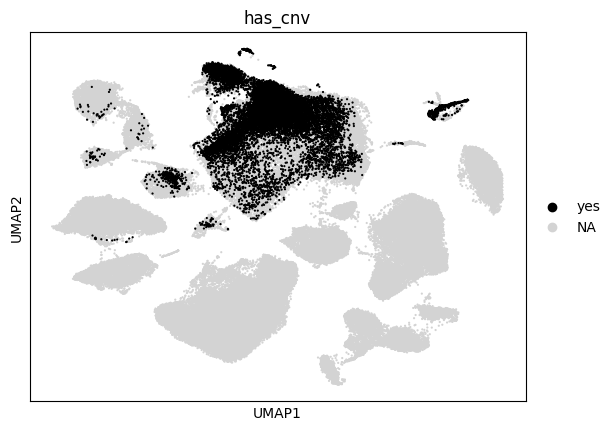

In [44]:
sc.pl.umap(adata_full, color='has_cnv', s=10, groups=['yes'])

## Barplots

03/31/2025 02:59:35 PM Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


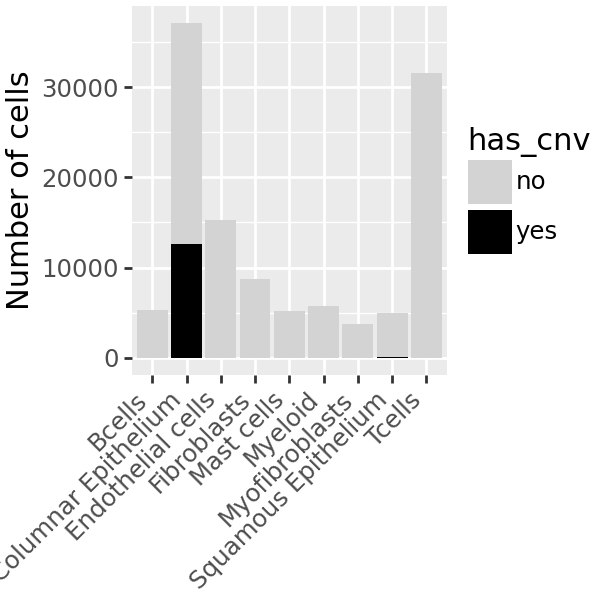

In [45]:
p = (
    pn.ggplot(adata_full.obs)
    + pn.aes('celltype_split', fill='has_cnv')
    + pn.geom_bar()
    # + pn.theme('void') 
    + pn.theme(figure_size=(3,3), axis_text_x=pn.element_text(rotation=45, hjust=1)) 
    + pn.scale_fill_manual(['lightgrey', 'black']) 
    + pn.labs(x='', y='Number of cells') 
)
# p.save('/tmp/cnv_proportions.svg')
p

/tmp/ipykernel_170500/3320676288.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
03/31/2025 02:59:36 PM Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


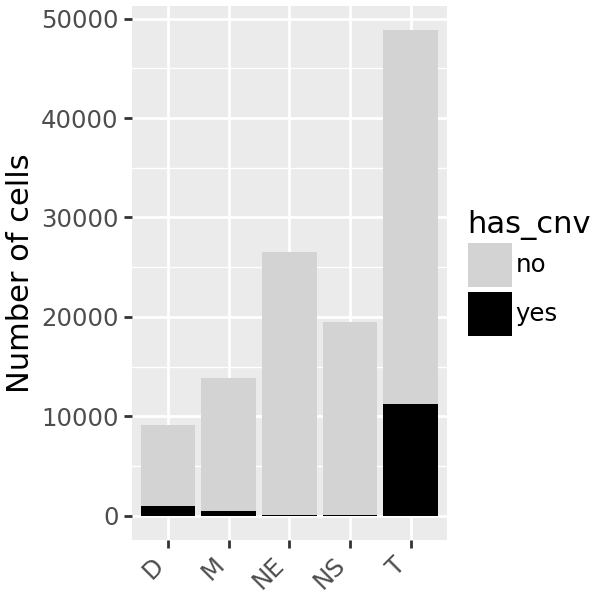

In [46]:
QQQ = adata_full.obs.copy().replace({'diagnosis': {'DT':'T', 'MDT':'T', 'MT':'T'}})
p = (
    pn.ggplot(QQQ)
    + pn.aes('diagnosis', fill='has_cnv')
    + pn.geom_bar()
    # + pn.theme('void') 
    + pn.theme(figure_size=(3,3), axis_text_x=pn.element_text(rotation=45, hjust=1)) 
    + pn.scale_fill_manual(['lightgrey', 'black']) 
    + pn.labs(x='', y='Number of cells') 
)
# p.save('/tmp/cnv_proportions.svg')
p